## Load Data

This dataset [Electricity Load Diagrams 20112014 Data Set](https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014#) is from UCI Machine Learning Repository.

### Data Set Information:

Data set has no missing values.
Values are in kW of each 15 min. To convert values in kWh values must be divided by 4.
Each column represent one client. Some clients were created after 2011. In these cases consumption were considered zero.
All time labels report to Portuguese hour. However all days present 96 measures (24*4). Every year in March time change day (which has only 23 hours) the values between 1:00 am and 2:00 am are zero for all points. Every year in October time change day (which has 25 hours) the values between 1:00 am and 2:00 am aggregate the consumption of two hours.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!curl https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip --output LD2011_2014.txt.zip
!unzip LD2011_2014.txt.zip
!ls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  249M  100  249M    0     0  50.2M      0  0:00:04  0:00:04 --:--:-- 50.2M
Archive:  LD2011_2014.txt.zip
  inflating: LD2011_2014.txt         
   creating: __MACOSX/
  inflating: __MACOSX/._LD2011_2014.txt  
LD2011_2014.txt  LD2011_2014.txt.zip  __MACOSX	sample_data


In [2]:
# url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip'
df = pd.read_csv("LD2011_2014.txt", sep = ';', index_col = 0, dtype=str)

In [3]:
print(df.shape)

(140256, 370)


# Data processing & Pre-Modeling

TODO: FB Prophet, split subsets

## Data Cleaning

- Melt the wide data matrix to long data matrix
- Convert index to timestamps, entries to numeric

In [4]:
def preprocessing(dataframe):
    # convert index (timestamp) to a new column
    dataframe = dataframe.reset_index().rename(columns={"index": "timestamp"})

    # unpivot the data
    dataframe = dataframe.melt(id_vars=['timestamp'], var_name='user', value_name='usage_per_15min')
    # fix the timestamp
    dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'], format = '%Y-%m-%d %H:%M:%S')
    # fix electricity usage
    dataframe['usage_per_15min'] = dataframe['usage_per_15min'].apply(lambda x: str(x).replace(',', '.')).astype(float)

    return dataframe

df = preprocessing(df)

In [5]:
df.tail(10)

,timestamp,user,usage_per_15min
51894710,2014-12-31 21:45:00,MT_370,8594.594595
51894711,2014-12-31 22:00:00,MT_370,7891.891892
51894712,2014-12-31 22:15:00,MT_370,7945.945946
51894713,2014-12-31 22:30:00,MT_370,7351.351351
51894714,2014-12-31 22:45:00,MT_370,7189.189189
51894715,2014-12-31 23:00:00,MT_370,7621.621622
51894716,2014-12-31 23:15:00,MT_370,6702.702703
51894717,2014-12-31 23:30:00,MT_370,6864.864865
51894718,2014-12-31 23:45:00,MT_370,6540.540541
51894719,2015-01-01 00:00:00,MT_370,7135.135135


In [6]:
# aggregate the data to daily level
def aggregate_date(dataframe):
    dataframe['date'] = pd.to_datetime((dataframe.timestamp - np.timedelta64(1, 'm')).dt.date)
    dataframe_day = dataframe.groupby(['user', 'date']).sum().reset_index()
    dataframe_day = dataframe_day.rename(columns={'usage_per_15min': 'sum_per_day'})
    #dataframe_day['std_per_day'] = dataframe.groupby(['user', 'date']).std().reset_index().usage_per_15min

    return dataframe_day

df_day = aggregate_date(df)
df_day.head()

,user,date,sum_per_day
0,MT_001,2011-01-01,0.0
1,MT_001,2011-01-02,0.0
2,MT_001,2011-01-03,0.0
3,MT_001,2011-01-04,0.0
4,MT_001,2011-01-05,0.0


## Create features

ex. cyclic features

In [7]:
def feature_engineering_net(dataframe_raw):
    dataframe = dataframe_raw.copy(deep=True)
    dataframe.sort_values(by=["user", "date"]).reset_index(drop=True, inplace=True)
    dataframe['target'] = dataframe.groupby('user')['sum_per_day'].shift(-365)

    dataframe['feat_year'] = dataframe['date'].dt.year
    dataframe['feat_month'] = dataframe['date'].dt.month
    dataframe['feat_day'] = dataframe['date'].dt.day
    dataframe['feat_day_of_week'] = dataframe['date'].dt.dayofweek
    #dataframe[[f'feat_{dow}' for dow in ['Mon', 'Tue', 'Wed', 'Thr', 'Fri', 'Sat', 'Sun']]] = pd.get_dummies(dataframe.day_of_week)

    return dataframe

df_day_feat = feature_engineering_net(df_day)
    

$x_{\sin }=\sin \left(\frac{2 * \pi * x}{\max (x)}\right)$

$x_{\cos }=\cos \left(\frac{2 * \pi * x}{\max (x)}\right)$

In [8]:
# Cyclic Transformation
def cyclic_transformation(dataframe, features: list, drop=True):
    dataframe = dataframe.copy(deep=True)
    for feature in features:
        dataframe[f'{feature}_sin'] = np.sin((2*np.pi*dataframe[feature])/(np.max(dataframe[feature])))
        dataframe[f'{feature}_cos'] = np.cos((2*np.pi*dataframe[feature])/(np.max(dataframe[feature])))
    
    if drop:
        dataframe = dataframe[[col for col in dataframe.columns if col not in features]]

    return dataframe
seasonal_feats = ['feat_month', 'feat_day', 'feat_day_of_week']

df_day_feat = cyclic_transformation(df_day_feat, seasonal_feats)

In [9]:
def format_tweak(dataframe):
    '''
    In Seq2seq model, we do not need to shift the target variable, therefore we make 'sum_per_day' as the target variable
    Later we will use the resulting dataframe to create a custom PyTorch dataset
    '''
    dataframe = dataframe.copy(deep=True)
    dataframe['user'] = dataframe['user'].str[3:].astype(int)
    dataframe.drop(columns=['target'], inplace=True)
    dataframe.rename(columns={'sum_per_day': 'target'}, inplace=True)
    return dataframe

df_day_feat = format_tweak(df_day_feat)

In [10]:
df_day_feat.head()

,user,date,target,feat_year,feat_month_sin,feat_month_cos,feat_day_sin,feat_day_cos,feat_day_of_week_sin,feat_day_of_week_cos
0,1,2011-01-01,0.0,2011,0.5,0.866025,0.201299,0.979530,-8.660254e-01,0.5
1,1,2011-01-02,0.0,2011,0.5,0.866025,0.394356,0.918958,-2.449294e-16,1.0
2,1,2011-01-03,0.0,2011,0.5,0.866025,0.571268,0.820763,0.000000e+00,1.0
3,1,2011-01-04,0.0,2011,0.5,0.866025,0.724793,0.688967,8.660254e-01,0.5
4,1,2011-01-05,0.0,2011,0.5,0.866025,0.848644,0.528964,8.660254e-01,-0.5


In [11]:
df_day_feat.shape

(540570, 10)

In [12]:
df_day_feat.groupby('user').size().sort_values(ascending=True)

user
1      1461
252    1461
251    1461
250    1461
249    1461
       ... 
120    1461
119    1461
118    1461
127    1461
370    1461
Length: 370, dtype: int64

## Torch Dataset

The following code is to create a torch dataset for the data. The torch dataset is a class that inherits from torch.utils.data.Dataset. It is used to create a dataset that can be used by the torch dataloader. The torch dataloader is used to create batches of data for training and testing.

Each sample in the dataset is a dictionary with the following keys:

 - 'seq_feat': a tensor of shape (input_seq_len, num_seq_feat) containing the sequence features
 - 'cat_feat': a tensor of shape (input_seq_len, num_cat_feat) containing the categorical features (mostly user ids)
 - 'y': a tensor of shape (output_seq_len, 1) containing the target values



In [13]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class SequenceDataset(Dataset):
    def __init__(self, df, seq_feat_cols, cat_feat_cols, y_col,
                    embedding_sizes, seq_input_len, seq_output_len):

        self.df = df.sort_values(['user', 'date'], ascending=True)
        self.df = self.df.reset_index(drop=True)

        #print(self.df.head())
        self.seq_feat_cols = seq_feat_cols
        self.cat_feat_cols = cat_feat_cols
        self.y_col = y_col
        self.embedding_sizes = embedding_sizes
        self.seq_input_len = seq_input_len
        self.seq_output_len = seq_output_len

        self.num_users = self.df['user'].nunique()
        self.seq_len_perUser = self.df.shape[0] // self.num_users #seq length per user

        self.new_idx = []
        for i in range(0, self.num_users):
            seq_start_idx = self.seq_len_perUser * i
            seq_end_idx = seq_start_idx + (self.seq_len_perUser - self.seq_input_len - self.seq_output_len + 1) - 1
            
            for j in range(seq_start_idx, seq_end_idx+1):
                self.new_idx.append(j)
        

    def __len__(self):
        # each sample should be strictly sequential, assert(user.unique == 1)
        
        user_wise_len = self.df.shape[0]//self.num_users
        user_wise_num_seq = user_wise_len - self.seq_input_len - self.seq_output_len + 1
        #print(f"model_seq_len_perUser: {user_wise_num_seq}")
        return user_wise_num_seq * self.num_users

        #return self.df.shape[0] - self.seq_input_len - self.seq_output_len + 1 # 473426 for train, 201106 for test

    def __getitem__(self, idx):
        if idx >= len(self):
            raise IndexError
        idx = len(self) + idx if idx < 0 else idx
        if idx < 0:
            raise IndexError

        # split for each user 370 users
        ## 
        ## for train: 272690 total, 737 per user
        ##
        #user_group = np.ceil((idx+1) / (len(self)/self.num_users)).astype(np.int16)
        #print(f"user group:{user_group})")

        idx = self.new_idx[idx]

        seq_input_start_date = self.df.iloc[idx].date
        seq_input_end_date = self.df.iloc[idx + self.seq_input_len - 1].date
        seq_output_start_date = self.df.iloc[idx + self.seq_input_len].date
        seq_output_end_date = self.df.iloc[idx + self.seq_input_len + self.seq_output_len - 1].date

        # time series features
        seq_feat = self.df.loc[idx:idx+self.seq_input_len-1, self.seq_feat_cols].values
        seq_feat = torch.tensor(seq_feat, dtype=torch.float32)
        # categorical features
        cat_feat = self.df.loc[idx:idx+self.seq_input_len-1, self.cat_feat_cols].values
        cat_feat = torch.tensor(cat_feat, dtype=torch.long)
        # target
        y = self.df.loc[idx+self.seq_input_len:idx+self.seq_input_len+self.seq_output_len-1, self.y_col].values
        y = torch.tensor(y, dtype=torch.float32)
        y = y.view(-1, 1)
        
        assert len(torch.unique(cat_feat)) == 1 # assert user is same for this sample sequence

        return seq_feat, cat_feat, y#, self.embedding_sizes, seq_input_start_date, seq_input_end_date, seq_output_start_date, seq_output_end_date

    def _get_test_item(self, idx):
        if idx != 0:
            raise IndexError
        return self[-1]

In [ ]:
df_day_feat['user'].nunique()

370

## Train Test Split

In [ ]:
df_day_feat['date'].min(), df_day_feat['date'].max()

(Timestamp('2011-01-01 00:00:00'), Timestamp('2014-12-31 00:00:00'))

In [14]:
# split the data
IN_SEQ_LEN = 60 # 60 days as input
OUT_SEQ_LEN = 30 # 30 days as output
train_test_cutoff = df_day_feat['date'].max() - pd.Timedelta(days=365) # we will use last 365 days as test data
train_val_cutoff = train_test_cutoff - pd.Timedelta(days=OUT_SEQ_LEN) - pd.Timedelta(days=30) #
print(f"train_test_cutoff: {train_test_cutoff}")
print(f"train_val_cutoff: {train_val_cutoff}")

test_start_date = train_test_cutoff - pd.Timedelta(days=IN_SEQ_LEN)
val_start_date = train_val_cutoff - pd.Timedelta(days=IN_SEQ_LEN)
test_end_date = train_test_cutoff + pd.Timedelta(days=OUT_SEQ_LEN) # we only predict OUT_SEQ_LEN days in test, otherwise there will be duplicate y hat for each y and we will need to choose which one to use
print(f"test_end_date: {test_end_date}")

train_df = df_day_feat.query('date <= @train_val_cutoff').copy().reset_index(drop=True)
val_df = df_day_feat.query('date > @val_start_date and date <= @train_test_cutoff').copy().reset_index(drop=True)
test_df = df_day_feat.query('date > @test_start_date and date <= @test_end_date').copy().reset_index(drop=True)

print(f"train_df: {train_df.shape}")
print(f"val_df: {val_df.shape}")
print(f"test_df: {test_df.shape}")

train_test_cutoff: 2013-12-31 00:00:00
train_val_cutoff: 2013-11-01 00:00:00
test_end_date: 2014-01-30 00:00:00
train_df: (383320, 10)
val_df: (44400, 10)
test_df: (33300, 10)


In [ ]:
train_df.columns
feature_cols = train_df.columns[train_df.columns.str.startswith('feat_')].tolist()
print(feature_cols)
print(train_df.columns)

['feat_year', 'feat_month_sin', 'feat_month_cos', 'feat_day_sin', 'feat_day_cos', 'feat_day_of_week_sin', 'feat_day_of_week_cos']
Index(['user', 'date', 'target', 'feat_year', 'feat_month_sin',
       'feat_month_cos', 'feat_day_sin', 'feat_day_cos',
       'feat_day_of_week_sin', 'feat_day_of_week_cos'],
      dtype='object')


In [ ]:
from sklearn.preprocessing import StandardScaler

target_scaler = StandardScaler()
feature_scaler = StandardScaler()

train_df['target'] = target_scaler.fit_transform(train_df['target'].values.reshape(-1, 1))
train_df[feature_cols] = feature_scaler.fit_transform(train_df[feature_cols])

val_df['target'] = target_scaler.transform(val_df['target'].values.reshape(-1, 1))
val_df[feature_cols] = feature_scaler.transform(val_df[feature_cols])

test_df['target'] = target_scaler.transform(test_df['target'].values.reshape(-1, 1))
test_df[feature_cols] = feature_scaler.transform(test_df[feature_cols])

train_dataset = SequenceDataset(
    df=train_df,
    seq_feat_cols = ['target'] + list(df_day_feat.columns[df_day_feat.columns.str.startswith('feat_')]),
    cat_feat_cols = ['user'],
    y_col = 'target',
    embedding_sizes = np.ceil(df_day_feat['user'].nunique() ** 0.5).astype(int),
    seq_input_len = IN_SEQ_LEN,
    seq_output_len = OUT_SEQ_LEN
)

val_dataset = SequenceDataset(
    df=val_df,
    seq_feat_cols = ['target'] + list(df_day_feat.columns[df_day_feat.columns.str.startswith('feat_')]),
    cat_feat_cols = ['user'],
    y_col = 'target',
    embedding_sizes = np.ceil(df_day_feat['user'].nunique() ** 0.5).astype(int),
    seq_input_len = IN_SEQ_LEN,
    seq_output_len = OUT_SEQ_LEN
)

test_dataset = SequenceDataset(
    df=test_df, 
    seq_feat_cols = ['target'] + list(df_day_feat.columns[df_day_feat.columns.str.startswith('feat_')]),
    cat_feat_cols = ['user'],
    y_col = 'target',
    embedding_sizes = np.ceil(df_day_feat['user'].nunique() ** 0.5).astype(int),
    seq_input_len = IN_SEQ_LEN,
    seq_output_len = OUT_SEQ_LEN
)

print(f'Train dataset size: {len(train_dataset)}')
print(f'Val dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')


Train dataset size: 350390
Val dataset size: 11470
Test dataset size: 370


### Dataloader


In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE = 1024 if torch.cuda.is_available() else 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

for seq_feat, cat_feat, y in train_loader:
    print(seq_feat.shape, cat_feat.shape, y.shape)
    break

print(f"each batch dim: {next(iter(train_loader))[0].shape}")

torch.Size([1024, 60, 8]) torch.Size([1024, 60, 1]) torch.Size([1024, 30, 1])
each batch dim: torch.Size([1024, 60, 8])


In [ ]:
# Seq2seq
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
class Seq2seqEncoder(nn.Module):
    def __init__(self,
                 input_seq_len = 365,
                 feature_size = 1,
                 hidden_size = 128,
                 num_layers = 8,
                 num_classes = 370,
                 embed_size = 20,
                 bidirectional = False,
                 dropout_ratio = 0.2,
                 decoder_hidden_size = 128,
                 device = None):

        super(Seq2seqEncoder, self).__init__()
        self.input_seq_len = input_seq_len
        self.feature_size = feature_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes + 1
        self.embed_size = embed_size
        self.bidirectional = bidirectional
        self.dropout_ratio = dropout_ratio
        self.decoder_hidden_size = decoder_hidden_size
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        self.embedding = nn.Embedding(self.num_classes, self.embed_size) # condition on sequence

        self.gru = nn.GRU(
            input_size = feature_size, # number of features
            hidden_size = hidden_size,
            num_layers = num_layers,
            bidirectional = bidirectional,
            dropout = dropout_ratio,
            batch_first = True
        )

        
        self.num_directions = 2 if bidirectional else 1
        
        self.embed_to_hidden = nn.Linear(self.embed_size, self.hidden_size)
        self.encHidden_to_decHidden = nn.Linear(self.hidden_size * self.num_directions, self.decoder_hidden_size)

        self.batch_norm = nn.BatchNorm1d(self.decoder_hidden_size)

    def forward(self, data_loader_batch):
        # data_loader_batch: (seq_len, batch_size, feature_size)
        #print(f"input shape: {data_loader_batch.shape}")
        seq_feat, cat_feat, y = data_loader_batch
        seq_feat = seq_feat.to(self.device)
        cat_feat = cat_feat.to(self.device)
        y = y.to(self.device)
        batch_size = seq_feat.shape[0]
        #print(f"max cat_feat: {torch.max(cat_feat)}")
        #print(f"min cat_feat: {torch.min(cat_feat)}")
        #print(f"seq_feat shape: {seq_feat.shape}")
        #print(f"cat_feat shape: {cat_feat.shape}")
        #print(f"y shape: {y.shape}")
        #print(f"cat_feat: {cat_feat}")
        #print(f"y: {y}")

        # embed categorical features
        # just use the first one
        cat_feat = cat_feat[:, 0, :]
        #print(f"cat_feat shape: {cat_feat.shape}")
        cat_feat = cat_feat.view(-1)
        #print(f"cat_feat: {cat_feat}")
        #print(cat_feat.get_device())
        embed_vector = self.embedding(cat_feat).requires_grad_(True)#.to(device)
        #print(f"ht shape: {ht.shape}")
        #print(f"ht: {ht}")
        ht = self.embed_to_hidden(embed_vector)
        #print(f"ht shape: {ht.shape}")
        ht = ht.repeat(self.num_layers * self.num_directions, 1, 1)
        #print(f"ht shape: {ht.shape}")

        # pass through GRU
        # output: (batch_size, seq_len, hidden_size * num_directions)
        # hidden: (num_layers * num_directions, batch_size, hidden_size)
        output, hidden = self.gru(seq_feat, ht)

        #print(f"output shape: {output.shape}")
        #print(f"hidden shape: {hidden.shape}")
        if self.bidirectional:
            # hidden = [forward_1, backward_1, forward_2, backward_2, ...]
            # hidden[-2, :, :] is the last of the forwards RNN
            # hidden[-1, :, :] is the last of the backwards RNN

            # output := [forward, backward]
            # output = output[:, :, :self.hidden_size] + output[:, : ,self.hidden_size:]
            #print(f"output shape, after sum: {output.shape}")
            hidden = hidden.view(self.num_layers, 2, batch_size, self.hidden_size)
            hidden = torch.cat((hidden[:, 0, :, :], hidden[:, 1, :, :]), dim = 1)
            #print(f"hidden shape, after cat: {hidden.shape}")

        else:
            hidden = hidden[-1, :, :]
            #print(f"hidden shape, last: {hidden.shape}")

        # transform hidden state dim to match decoder hidden dim
        hidden = self.encHidden_to_decHidden(hidden)
        #hidden = self.batch_norm(hidden)
        #print(f"hidden shape, after transform: {hidden.shape}")
        return output, hidden, embed_vector

class Attention(nn.Module):
    # arXiv:1409.0473
    def __init__(self, encoder_hidden_size, decoder_hidden_size, bidirectional):
        super(Attention, self).__init__()
        self.encoder_hidden_size = encoder_hidden_size
        self.decoder_hidden_size = decoder_hidden_size
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        self.attn = nn.Linear(self.encoder_hidden_size * self.num_directions + self.decoder_hidden_size, decoder_hidden_size)
        #print(self.attn)
        self.v = nn.Linear(decoder_hidden_size, 1, bias=False)

    def forward(self, hidden, encoder_outputs, bidirectional):
        # hidden = [batch size, dec hid dim] (last input hidden state)
        # encoder_outputs = [batch size, src len, enc hid dim * num directions]

        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]

        # repeat decoder hidden state src_len times
        # hidden = [batch size, src len, dec hid dim]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        #print(hidden.shape)
        #print(encoder_outputs.shape)
        #print(self.encoder_hidden_size * self.num_directions + self.decoder_hidden_size)
        #print(torch.cat((hidden, encoder_outputs), dim=2).shape)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2))) # [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2) # [batch size, src len]

        return F.softmax(attention, dim=1)


class Seq2seqDecoder(nn.Module):
    def __init__(self,
                 input_seq_len,
                 feature_size,
                 hidden_size = 128,
                 num_layers = 8,
                 num_classes = 370,
                 embed_size = 20,
                 output_seq_len = 365,
                 bidirectional = False,
                 dropout_ratio = 0.2,
                 decoder_hidden_size = 128,
                 encoder_hidden_size = 128,
                 attention = None,
                 use_attention = True):

        super(Seq2seqDecoder, self).__init__()
        self.input_seq_len = input_seq_len
        self.feature_size = feature_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes + 1
        self.embed_size = embed_size
        self.output_seq_len = output_seq_len
        self.bidirectional = bidirectional
        self.dropout_ratio = dropout_ratio
        self.decoder_hidden_size = decoder_hidden_size
        self.encoder_hidden_size = encoder_hidden_size
        self.attention = attention
        self.num_directions = 2 if self.bidirectional else 1
        self.use_attention = use_attention
        
        self.repeat_label_times = int(np.ceil(self.encoder_hidden_size * self.num_directions / 2))

        self.gru = nn.GRU(
            input_size = self.encoder_hidden_size * self.num_directions + self.repeat_label_times + self.embed_size, #input_size = self.encoder_hidden_size * 4 if self.bidirectional else self.encoder_hidden_size * 2,
            hidden_size = self.decoder_hidden_size,
            num_layers = self.num_layers,
            batch_first = True
        )
        
        #self.fc_out = nn.Linear(self.decoder_hidden_size + self.encoder_hidden_size * self.num_directions + 1, 1)
        self.fc_out = nn.Linear(self.decoder_hidden_size + self.encoder_hidden_size * self.num_directions, 1)

        self.dropout = nn.Dropout(self.dropout_ratio)

    def forward(self, dec_input, s, enc_output, embed_vector, attention=True):
        # dec_input = [batch size]
        # s = [batch size, dec hid dim] first time: hidden state of the encoder, after: previous hidden state of the decoder
        # enc_output = [batch size, src len, enc hid dim * num directions]

        # attention  a = [batch size, src len]
        #print(f"s shape {s.shape}")
        #print(f"enc_output {enc_output.shape}")
        if attention:
            a = self.attention(s, enc_output, self.bidirectional)
            # [batch size, 1, src len]
            a = a.unsqueeze(1)

            c = torch.bmm(a, enc_output) # [batch size, 1, enc hid dim * num directions] # context vector
        else:
            # only preserve the hidden state from encoder or previous iter. decoder hidden state
            c = s.unsqueeze(1) # [batch size, 1, dec hid dim]
        # dec_input = [batch size, 1, 1]
        dec_input = dec_input.unsqueeze(1).unsqueeze(2)
        # dec_input = [batch size, 1, enc hid dim * num directions]
        dec_input_repeat = dec_input.repeat(1, 1, self.repeat_label_times)

        embed_vector = embed_vector.unsqueeze(1) # [batch size, 1, embed_size]

        gru_input = torch.cat((dec_input_repeat, embed_vector, c), dim=2) # [batch size, 1, (enc hid dim * num directions) + num_repeat_label]
        # hidden state of the decoder
        s = s.repeat(self.num_layers, 1, 1)

        # gru_output = [batch size, 1, dec hid dim], s = [n_layer, batch size, dec hid dim]
        gru_output, s = self.gru(gru_input, s)
        s = s[-1, :, :] # [batch size, dec hid dim] # last layer hidden state

        c = c.squeeze(1) # [batch size, enc hid dim * num directions]
        #dec_input = dec_input # [batch size, 1]
        gru_output = gru_output.squeeze(1) # [batch size, dec hid dim]
        # add dropout
        gru_output = self.dropout(gru_output)
        #prediction = self.fc_out(torch.cat((gru_output, c, dec_input.squeeze(2)), dim=1)) # [batch size, 1]
        prediction = self.fc_out(torch.cat((gru_output, c), dim=1))
        prediction = prediction.squeeze(1) # [batch size]
        return prediction, s

class Seq2seq(nn.Module):
    def __init__(self,
                 encoder,
                 decoder,
                 device):
        super(Seq2seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, input_batch, teacher_forcing_ratio = 0.5, inference = False):

        # input_batch = input batch
        # trg = [batch size, trg len] target time series
        # teacher_forcing_ratio is probability to use teacher forcing
        inference = not self.training
        batch_size = input_batch[0].shape[0]
        src = input_batch[0][:, :, 0].to(self.device) # dim = [batch size, src len]
        trg = input_batch[2][:, :, 0].to(self.device) # dim = [batch size, trg len]
        trg_len = trg.shape[1]
        # tensor to store decoder outputs
        # [batch size, trg len]
        outputs = torch.zeros(batch_size, trg_len).to(self.device)

        # last hidden state of the encoder is used as the initial hidden state of the decoder
        enc_output, s, embed_vector = self.encoder(input_batch)
        # feed y(t-1) to the decoder
        dec_input = src[:, -1] # [batch size]
        #dec_input = torch.zeros(batch_size, 1).squeeze(1).to(self.device)

        for t in range(0, trg_len):
            # insert dec_input, previous hidden state and all encoder hidden states and outputs
            # receive output tensor (predictions) and new hidden state
            # dec_output = [batch size]
            # s = [batch size, dec hid dim] last hidden state of the decoder
            dec_output, s = self.decoder(dec_input, s, enc_output, embed_vector) 
            # outputs dim: [batch size, trg len]
            #print(dec_output.shape)
            #print(outputs[:, t].shape)
            outputs[:, t] = dec_output

            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            teacher_force = False if inference else teacher_force
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            dec_input = trg[:, t] if teacher_force else dec_output

        return outputs
        


# test
seq2seq_encoder_oneDirection = Seq2seqEncoder(
    input_seq_len = 365,
    feature_size = next(iter(train_loader))[0].shape[-1],
    hidden_size = 128,
    num_layers = 8,
    num_classes = 370,
    embed_size = 20,
    bidirectional = False,
    dropout_ratio = 0.2
)
seq2seq_encoder_twoDirection = Seq2seqEncoder(
    input_seq_len = 365,
    feature_size = next(iter(train_loader))[0].shape[-1],
    hidden_size = 128,
    num_layers = 8,
    num_classes = 370,
    embed_size = 20,
    bidirectional = True,
    dropout_ratio = 0.2
)

#seq2seq_encoder_oneDirection(next(iter(train_loader)))
#seq2seq_encoder_twoDirection(next(iter(train_loader)))

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# test
ENCODER_HIDDEN_SIZE = 128
DECODER_HIDDEN_SIZE = 128
EMBED_SIZE = 20
ENCODER_NUM_LAYERS = 4 #for 180 6
DECODER_NUM_LAYERS = 2
ENCODER_BIDIRECTIONAL = False

encoder_test = Seq2seqEncoder(
    input_seq_len = IN_SEQ_LEN,
    feature_size = next(iter(train_loader))[0].shape[-1],
    hidden_size = ENCODER_HIDDEN_SIZE,
    num_layers = ENCODER_NUM_LAYERS,
    num_classes = 370,
    embed_size = EMBED_SIZE,
    bidirectional = ENCODER_BIDIRECTIONAL,
    dropout_ratio = 0.3,
    decoder_hidden_size = DECODER_HIDDEN_SIZE
).cuda()
attention_test = Attention(encoder_hidden_size = ENCODER_HIDDEN_SIZE, decoder_hidden_size = DECODER_HIDDEN_SIZE, bidirectional = ENCODER_BIDIRECTIONAL).cuda()
decoder_test = Seq2seqDecoder(
    input_seq_len = IN_SEQ_LEN,
    feature_size = next(iter(train_loader))[0].shape[-1],
    hidden_size = ENCODER_HIDDEN_SIZE,
    num_layers = DECODER_NUM_LAYERS,
    num_classes = 370,
    embed_size = EMBED_SIZE,
    output_seq_len = OUT_SEQ_LEN,
    bidirectional = ENCODER_BIDIRECTIONAL,
    dropout_ratio = 0.3,
    decoder_hidden_size = DECODER_HIDDEN_SIZE,
    encoder_hidden_size = ENCODER_HIDDEN_SIZE,
    attention = attention_test).cuda()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
#device = torch.device('mps')
seq2seq_test = Seq2seq(encoder_test, decoder_test, device).cuda()
#seq2seq_test(next(iter(train_loader)))

cuda:0


In [ ]:
seq2seq_test(next(iter(train_loader)))

tensor([[-0.0191, -0.0270, -0.0016,  ..., -0.0033,  0.0115, -0.0098],
        [-0.0741, -0.0778, -0.0839,  ..., -0.1033, -0.0893, -0.0632],
        [-0.0665, -0.0482, -0.0760,  ..., -0.0630, -0.0568, -0.0585],
        ...,
        [-0.0547, -0.0279, -0.0231,  ..., -0.0169, -0.0003, -0.0339],
        [-0.0549, -0.0224, -0.0258,  ..., -0.0566,  0.0086, -0.0263],
        [-0.0391,  0.0101, -0.0182,  ...,  0.0347,  0.0258,  0.0507]],
       device='cuda:0', grad_fn=<CopySlices>)

In [ ]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [ ]:
# train
import datetime
#!pip install torchmetrics --quiet
#import torchmetrics
from torch import optim
import tqdm
N_EPOCHS = 20
#CRITERION = torchmetrics.MeanAbsolutePercentageError().cuda()
CRITERION = RMSELoss().cuda()
CRITERION = nn.MSELoss()
def train(model, iterator, criterion):
    
    epoch_loss = 0
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.train()

    with tqdm.tqdm(total=len(iterator)) as pbar:
        for i, batch in enumerate(iterator):
            optimizer.zero_grad()
            output = model(batch)
            real_target = batch[2][:, :, 0].to(device)
            loss = criterion(output, real_target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            pbar.set_postfix(loss=loss.item())
            pbar.update(1)
    
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    
    with torch.no_grad():
        with tqdm.tqdm(total=len(iterator)) as pbar:
            for i, batch in enumerate(iterator):
                output = model(batch, inference = True)
                real_target = batch[2][:, :, 0].to(device)
                loss = criterion(output, real_target)
                epoch_loss += loss.item()
                pbar.set_postfix(loss=loss.item())
                pbar.update(1)
    
    return epoch_loss / len(iterator)

def train_model(model, train_iterator, valid_iterator, criterion, n_epochs):
    best_valid_loss = float('inf')
    train_losses = []
    valid_losses = []
    for epoch in range(n_epochs):
        train_loss = train(model, train_iterator, criterion)
        valid_loss = evaluate(model, valid_iterator, criterion)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f"./gdrive/MyDrive/project-ML/full-length-seq2seq-{datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}.pt")
        print(f'Epoch: {epoch+1:02}')
        print(f'\tTrain Loss: {train_loss:.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f}')
    return train_losses, valid_losses



In [ ]:
train_losses, valid_losses = train_model(seq2seq_test, train_loader, val_loader, CRITERION, N_EPOCHS)

model_save_name = 'seq2seq.pt'
path = f"./gdrive/MyDrive/project-ML/full-length-{model_save_name}-{datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}" 
torch.save(seq2seq_test.state_dict(), path)

100%|██████████| 12/12 [00:23<00:00,  1.92s/it, loss=0.302]


Epoch: 01
	Train Loss: 0.136
	 Val. Loss: 0.047


100%|██████████| 12/12 [00:23<00:00,  1.92s/it, loss=0.304]


Epoch: 02
	Train Loss: 0.043
	 Val. Loss: 0.034


100%|██████████| 12/12 [00:22<00:00,  1.91s/it, loss=0.281]


Epoch: 03
	Train Loss: 0.033
	 Val. Loss: 0.031


100%|██████████| 12/12 [00:23<00:00,  1.92s/it, loss=0.241]


Epoch: 04
	Train Loss: 0.026
	 Val. Loss: 0.027


100%|██████████| 12/12 [00:23<00:00,  1.92s/it, loss=0.26]


Epoch: 05
	Train Loss: 0.023
	 Val. Loss: 0.033


100%|██████████| 12/12 [00:23<00:00,  1.92s/it, loss=0.242]


Epoch: 06
	Train Loss: 0.020
	 Val. Loss: 0.030


100%|██████████| 12/12 [00:22<00:00,  1.92s/it, loss=0.233]


Epoch: 07
	Train Loss: 0.018
	 Val. Loss: 0.024


100%|██████████| 12/12 [00:23<00:00,  1.92s/it, loss=0.24]


Epoch: 08
	Train Loss: 0.017
	 Val. Loss: 0.025


100%|██████████| 12/12 [00:22<00:00,  1.90s/it, loss=0.304]


Epoch: 09
	Train Loss: 0.015
	 Val. Loss: 0.031


100%|██████████| 12/12 [00:23<00:00,  1.92s/it, loss=0.242]


Epoch: 10
	Train Loss: 0.014
	 Val. Loss: 0.025


100%|██████████| 12/12 [00:22<00:00,  1.90s/it, loss=0.327]


Epoch: 11
	Train Loss: 0.014
	 Val. Loss: 0.031


100%|██████████| 12/12 [00:23<00:00,  1.92s/it, loss=0.248]


Epoch: 12
	Train Loss: 0.013
	 Val. Loss: 0.031


100%|██████████| 12/12 [00:22<00:00,  1.91s/it, loss=0.339]


Epoch: 13
	Train Loss: 0.013
	 Val. Loss: 0.033


100%|██████████| 12/12 [00:22<00:00,  1.91s/it, loss=0.232]


Epoch: 14
	Train Loss: 0.012
	 Val. Loss: 0.026


100%|██████████| 12/12 [00:22<00:00,  1.91s/it, loss=0.225]


Epoch: 15
	Train Loss: 0.011
	 Val. Loss: 0.022


100%|██████████| 12/12 [00:23<00:00,  1.92s/it, loss=0.238]


Epoch: 16
	Train Loss: 0.011
	 Val. Loss: 0.030


100%|██████████| 12/12 [00:22<00:00,  1.91s/it, loss=0.23]


Epoch: 17
	Train Loss: 0.011
	 Val. Loss: 0.025


100%|██████████| 12/12 [00:23<00:00,  1.93s/it, loss=0.329]


Epoch: 18
	Train Loss: 0.010
	 Val. Loss: 0.047


100%|██████████| 12/12 [00:22<00:00,  1.91s/it, loss=0.224]


Epoch: 19
	Train Loss: 0.011
	 Val. Loss: 0.023


100%|██████████| 12/12 [00:23<00:00,  1.93s/it, loss=0.256]

Epoch: 20
	Train Loss: 0.010
	 Val. Loss: 0.025


In [ ]:
print(train_losses)
print(valid_losses)

In [ ]:
# load model
seq2seq_test.load_state_dict(torch.load('./gdrive/MyDrive/project-ML/full-length-seq2seq.pt-2022-10-15-00-07-39'))


<All keys matched successfully>

In [ ]:
# plot train and validation loss
import matplotlib.pyplot as plt
plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='validation')
plt.legend()
plt.show()

In [ ]:
import gc
torch.cuda.empty_cache()
try:
    del encoder_test
    del decoder_test
    del attention_test
    del seq2seq_test
except:
    pass
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()

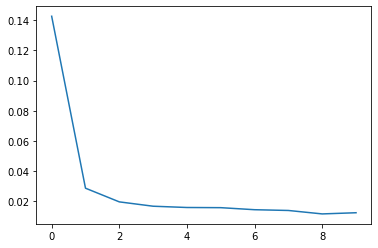

In [ ]:
plt.plot(losses)

In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
def test(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    with torch.no_grad():
        for i, batch in tqdm.tqdm(enumerate(iterator)):
            output = model(batch, inference=True)
            real_target = batch[2][:, :, 0].to(device)
            loss = criterion(output, real_target)
            epoch_loss += loss.item()
            tqdm.tqdm.write(f'loss: {loss.item()}')
    return epoch_loss / len(iterator) # loss per batch

test_loss = test(seq2seq_test, test_loader, CRITERION)
print(test_loss)

1it [00:01,  1.33s/it]

loss: 0.010146934539079666
0.010146934539079666


In [ ]:
# transform back to original scale
def inverse_transform(data, scaler):
    return scaler.inverse_transform(data)

# predict
def predict(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    outputs = torch.empty(BATCH_SIZE, OUT_SEQ_LEN).to(device) # y hat
    batches_features = torch.empty(next(iter(iterator))[0].shape).to(device)
    batches_user = torch.empty(next(iter(iterator))[1].shape).to(device)
    batches_y = torch.empty(next(iter(iterator))[2].shape).squeeze(2).to(device)
    print(outputs.shape, batches_features.shape, batches_user.shape, batches_y.shape)
    with torch.no_grad():
        for i, batch in tqdm.tqdm(enumerate(iterator)):
            output = model(batch, inference=True)
            #real_target = batch[2][:, :, 0].to(device)
            loss = criterion(output, batch[2][:, :, 0].to(device))
            epoch_loss += loss.item()
            tqdm.tqdm.write(f'loss: {loss.item()}')
            # inverse transform
            #output = inverse_transform(output, scaler)
            #real_target = inverse_transform(real_target, scaler)
            outputs = torch.cat((outputs, output), dim = 0)
            batches_features = torch.cat((batches_features, batch[0].to(device)), dim = 0)
            batches_user = torch.cat((batches_user, batch[1].to(device)), dim = 0)
            batches_y = torch.cat((batches_y, batch[2][:, :, 0].to(device)), dim = 0)
            
        return outputs, (batches_features, batches_user, batches_y)

y_hat, test_batch = predict(seq2seq_test, test_loader, CRITERION)


torch.Size([1024, 30]) torch.Size([370, 60, 8]) torch.Size([370, 60, 1]) torch.Size([370, 30])


1it [00:00,  1.32it/s]

loss: 0.010146934539079666


In [ ]:
y_hat = y_hat[BATCH_SIZE:,:]
test_batch = [_[370:, :, :] if len(_.shape) > 2 else _[370:, :] for _ in test_batch]


In [ ]:
y_hat.shape
test_batch[0].shape
test_batch[1].shape
test_batch[2].shape

torch.Size([370, 30])

In [ ]:
def construct_df(output, batch):
    # batch[0] = time series features (batch_size, in_seq_len, feature_size)
    # batch[1] = static user flag (batch_size, in_seq_len, 1)
    # batch[2] = target (batch_size, out_seq_len, 1)

    # output = (batch_size, out_seq_len)
    if output.shape[1] != batch[1].shape[1]:
        users = batch[1][:, :output.shape[1], 0].cpu().numpy()
    else:
        users = batch[1][:, :, 0].cpu().numpy()
    users = users.reshape(-1)

    y_hat = output.cpu().numpy()
    y_hat = y_hat.reshape(-1)

    y = batch[2].cpu().numpy()
    y = y.reshape(-1)

    
    day = list(range(1, (output.shape[1] + 1))) * batch[1].shape[0]
    #print(len(day), print())
    df = pd.DataFrame({'user': users, 'day': day, 'y_hat': y_hat, 'y': y})

    return df

df_pred = construct_df(y_hat, test_batch)

In [ ]:
df_pred['user'] = df_pred['user'].astype(int)
df_pred

,user,day,y_hat,y
0,1,1,-0.173536,-0.178633
1,1,2,-0.173553,-0.178496
2,1,3,-0.181614,-0.178425
3,1,4,-0.183766,-0.178719
4,1,5,-0.184071,-0.178591
...,...,...,...,...
11095,370,26,5.812806,2.931079
11096,370,27,5.820715,3.380300
11097,370,28,5.827989,4.472764
11098,370,29,5.835185,4.620553


In [ ]:
for user in df_pred['user'].unique():
    fig, ax = plt.subplots(figsize=(10, 5))
    df_user = df_pred[df_pred['user'] == user]
    ax.plot(df_user['day'], df_user['y_hat'], label=f'user {user}', alpha=0.5, linestyle = '--')
    ax.plot(df_user['day'], df_user['y'], label=f'user {user}')
    #plt.legend()
    plt.title(f"user: {user}")
    plt.show()
    

In [ ]:
df_pred['y'] = target_scaler.inverse_transform(df_pred['y'].values.reshape(-1,1))
df_pred['y_hat'] = target_scaler.inverse_transform(df_pred['y_hat'].values.reshape(-1,1))

In [ ]:
df_pred

,user,day,y_hat,y
0,1,1,1.555028e+03,1.903563e+02
1,1,2,1.550559e+03,2.271571e+02
2,1,3,-6.077218e+02,2.461922e+02
3,1,4,-1.183804e+03,1.675125e+02
4,1,5,-1.265519e+03,2.017782e+02
...,...,...,...,...
11095,370,26,1.604284e+06,8.327568e+05
11096,370,27,1.606402e+06,9.530271e+05
11097,370,28,1.608349e+06,1.245514e+06
11098,370,29,1.610276e+06,1.285081e+06
